<a href="https://colab.research.google.com/github/eman-kom/tensorflow-fundamentals/blob/main/09_SkimLit_Milestone_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
NLP model to make reading medical abstracts easier

## Paper referenced:
* [https://arxiv.org/abs/1710.06071](https://arxiv.org/abs/1710.06071)
* [https://arxiv.org/abs/1612.05251](https://arxiv.org/abs/1612.05251)

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fc001bbf-fd6e-97bd-36ee-53340ce763c2)


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import calculate_results

--2022-07-13 15:49:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-13 15:49:26 (96.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Getting & Pre-Processing Data
Source: [https://github.com/Franck-Dernoncourt/pubmed-rct](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [5]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [6]:
!head pubmed-rct/PubMed_20k_RCT/train.txt

###24293578
OBJECTIVE	To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
METHODS	A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .
METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
METHODS	Pain was assessed using the visual analog pain scale ( 0-100 mm ) .
METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .
METHODS	Serum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein

In [7]:
!head pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt

###24293578
OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .
METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .
METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .
METHODS	Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP 

In [8]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [9]:
def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()

In [10]:
train_lines = get_lines(data_dir+"/train.txt")
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [11]:
for i in enumerate(train_lines[:10]):
  print(i)

(0, '###24293578\n')
(1, 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n')
(2, 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n')
(3, 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n')
(4, 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n')
(5, 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n')
(6, 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis fa

In [12]:
def preprocess_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []
  
 
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

     
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target, text = abstract_line.split("\t")
        line_data["target"] = target
        line_data["text"] = text.lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    
    else:
      abstract_lines += line
  
  return abstract_samples

In [13]:
%%time
train_samples = preprocess_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 396 ms, sys: 94.4 ms, total: 490 ms
Wall time: 499 ms


# Visualising Dataset

In [14]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [15]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

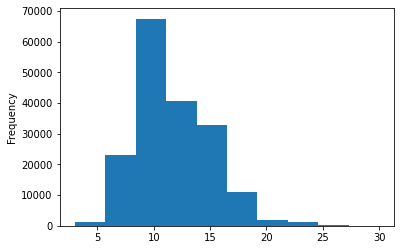

In [16]:
train_df.total_lines.plot.hist();

In [17]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

# Encoding labels

In [18]:
# one hot encoding
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
# Encode Labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

# Model 0: Baseline Model, TF-IDF Multinomial Naive Bayes Classifier

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(
    train_sentences,
    train_labels_encoded
)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [23]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

# Preparing text for deep learning

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [26]:
sent_lengths = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lengths = np.mean(sent_lengths)
avg_sent_lengths

26.338269273494777

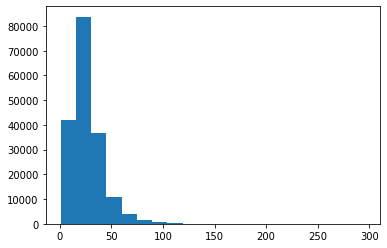

In [27]:
import matplotlib.pyplot as plt
plt.hist(sent_lengths, bins=20);

In [28]:
output_seq_len = int(np.percentile(sent_lengths, 95))
output_seq_len

55

In [29]:
max(sent_lengths)

296

## Vectorizing on training sentences

In [30]:
MAX_TOKENS = 68000

In [31]:
from tensorflow.keras.layers import TextVectorization

In [32]:
vectorizer = TextVectorization(
    max_tokens=MAX_TOKENS,
    output_sequence_length=output_seq_len
)

In [33]:
vectorizer.adapt(train_sentences)

In [34]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text:\n{len(target_sentence.split())}")
print(f"\nVectorized Text:\n{vectorizer([target_sentence])}")

Text:
parameters to identify eligible patients are as follows : estro : > @ years , invasive ductal carcinoma/other favorable histology ( idc ) , t@-@ ( @ cm ) , n@ , any hormone receptor status , m@ ; astro : @ years , idc , t@ , n@ , positive estrogen hormone receptor status , m@ ; targit e `` elderly '' , risk adapted radiotherapy with iort followed by external beam radiotherapy in case of risk factors in final histopathology , phase ii : @ years , idc , t@ , n@ , any hormone receptor status , m@ ; targit c `` consolidation '' , risk adapted radiotherapy , phase iv : @ years , idc , t@ , n@ , positive hormone receptor status , m@ ; targit bqr `` boost quality registry '' : every age , every histology , t@-@ ( max .

Length of text:
149

Vectorized Text:
[[  315     6   715   518    12    58    25  2526 23202    64  1213  7543
  62077  1599  3820 26187   206   520    40   262  1133   746   272   358
  21166    64 26187   206    40   280  3626  1133   746   272   358  7969
    949   8

In [35]:
rct_20k_vocab = vectorizer.get_vocabulary()
print(f"Word Count: {len(rct_20k_vocab)}")
print(f"Most common words: {rct_20k_vocab[:5]}")
print(f"Least common words: {rct_20k_vocab[-5:]}")

Word Count: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

## Creating Embedding

In [37]:
from tensorflow.keras.layers import Embedding 

In [38]:
embedding = Embedding(
    input_dim=len(rct_20k_vocab),
    output_dim=128,
    mask_zero=True,
    name="token_embedding"
)

In [39]:
print(f"Normal:\n{target_sentence}")
print(f"\nVectorized:\n{vectorizer([target_sentence])}")
print(f"\nVectorized shape: {vectorizer([target_sentence]).shape}")
print(f"\nEmbedding:\n{embedding(vectorizer([target_sentence]))}")
print(f"\nEmbedding shape: {embedding(vectorizer([target_sentence])).shape}")

Normal:
parameters to identify eligible patients are as follows : estro : > @ years , invasive ductal carcinoma/other favorable histology ( idc ) , t@-@ ( @ cm ) , n@ , any hormone receptor status , m@ ; astro : @ years , idc , t@ , n@ , positive estrogen hormone receptor status , m@ ; targit e `` elderly '' , risk adapted radiotherapy with iort followed by external beam radiotherapy in case of risk factors in final histopathology , phase ii : @ years , idc , t@ , n@ , any hormone receptor status , m@ ; targit c `` consolidation '' , risk adapted radiotherapy , phase iv : @ years , idc , t@ , n@ , positive hormone receptor status , m@ ; targit bqr `` boost quality registry '' : every age , every histology , t@-@ ( max .

Vectorized:
[[  315     6   715   518    12    58    25  2526 23202    64  1213  7543
  62077  1599  3820 26187   206   520    40   262  1133   746   272   358
  21166    64 26187   206    40   280  3626  1133   746   272   358  7969
    949   836    73  3091  1053    

# Creating Datasets

In [42]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [43]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>